In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gensim.downloader as api
import seaborn as sns
import tensorflow as tf
import string
import nltk
import mlflow
import mlflow.sklearn
import re
import time
import os
import pickle


from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.metrics import roc_curve

from gensim.models import Word2Vec

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.metrics import AUC
from tensorflow.keras.optimizers import Adam
from plot_keras_history import show_history, plot_history

from transformers import DistilBertTokenizerFast, create_optimizer, TFDistilBertForSequenceClassification

In [31]:
sample_size = 0.01

In [32]:
def log_experiment(model, params, metrics, artifacts, input_example, times):
    """
    Enregistre un modèle et ses performances dans MLflow.

    Cette fonction logge les hyperparamètres du modèle, les métriques fournies,
    ainsi que les artefacts associés. Elle enregistre également le temps d'entraînement
    (fit_time) et le temps de prédiction (predict_time) fournis dans le dictionnaire times.

    Parameters :
        model (sklearn.base.BaseEstimator): Le modèle entraîné à enregistrer.
        params (dict): Dictionnaire des hyperparamètres du modèle.
        metrics (dict): Dictionnaire des métriques à enregistrer (par exemple, 
                        "train_accuracy", "test_accuracy", "test_auc", etc.).
        artifacts (dict): Dictionnaire des artefacts à enregistrer (par exemple, 
                          "roc_curve", "cv_results", etc.). Les artefacts peuvent 
                          être des fichiers à enregistrer.
        input_example (pd.DataFrame ou np.ndarray): Exemple d'entrée pour la sérialisation du modèle.
        times (dict): Dictionnaire contenant "fit_time" et "predict_time", les temps d'entraînement
                      et de prédiction.

    Returns '
        None
    """
    with mlflow.start_run() as run:

        # Log des paramètres du modèle
        mlflow.log_params(params)

        # Log des métriques
        for metric_name, metric_value in metrics.items():
            mlflow.log_metric(metric_name, metric_value)

        # Log des temps
        for time_name, time_value in times.items():
            mlflow.log_metric(time_name, time_value)

        # Log du modèle
        mlflow.sklearn.log_model(model, 'model', input_example=input_example)

        # Enregistrement des artefacts
        for artifact_name, artifact_value in artifacts.items():
            mlflow.log_artifact(artifact_value)

        print(f'Modèle et résultats enregistrés dans MLFlow sous le run ID: {run.info.run_id}')

# 1. Préparation des données

In [33]:
col_names = ['target', 'ids', 'date', 'flag', 'user','text']
tweets = pd.read_csv('training.1600000.processed.noemoticon.csv',
                     encoding='latin-1',
                     header=None,
                     names=col_names
                    )

In [34]:
tweets

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


In [35]:
tweets['target'].value_counts()

target
0    800000
4    800000
Name: count, dtype: int64

In [36]:
tweets.nunique()

target          2
ids       1598315
date       774363
flag            1
user       659775
text      1581466
dtype: int64

In [37]:
def clean_tweet(tweet):
    # 1. Convertir en minuscules
    tweet = tweet.lower()

    # 2. Supprimer les mentions (@user)
    tweet = re.sub(r"@\w+", "", tweet)

    # 3. Remplacer les URLs par "URL"
    tweet = re.sub(r"http\S+|www\S+|https\S+", "URL", tweet, flags=re.MULTILINE)

    # 4. Gérer les hashtags (#word → word)
    tweet = re.sub(r"#(\w+)", r"\1", tweet)

    # 5. Réduire les répétitions de lettres (ex: coooool → cool)
    tweet = re.sub(r"(.)\1{2,}", r"\1\1", tweet)

    # 6. Supprimer la ponctuation excessive et les caractères spéciaux
    tweet = re.sub(r"[^a-zA-Z0-9\s]", "", tweet)

    return tweet

In [38]:
# # Fonction de lemmatization
# def lemmatize_text(text, lemmatizer):    
#     tokens = word_tokenize(text)  # Tokenizer le texte en mots
#     lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]
#     return ' '.join(lemmatized_tokens) # reassemble les tokens en phrases

In [39]:
# # Initialiser le lemmatizer
# lemmatizer = WordNetLemmatizer()
# # Appliquer la lemmatisation
# tweets['text'] = tweets['text'].apply(lambda x: lemmatize_text(x, lemmatizer))

In [40]:
tweets.reset_index(drop=True, inplace=True)

In [41]:
# Nettoyer les tweets
tweets["text"] = tweets["text"].apply(clean_tweet)

In [42]:
# on va utiliser un échantillion du jeu de données global
tweets_sample, _ = train_test_split(tweets, test_size=(1-sample_size),
                                    stratify=tweets['target'], random_state=42)

In [43]:
tweets_sample = tweets_sample[['target', 'text']]

In [44]:
# changer les valeurs de la target : 4 ==> 1
tweets_sample['target'] = tweets_sample['target'].map({0: 0, 4: 1})

In [45]:
tweets_sample.reset_index(drop=True, inplace=True)

In [46]:
tweets_sample

,target,text
0,1,ugh studying today last final tomorrow then su...
1,0,some times the time stops moving it looks like...
2,1,lovin this sunshine was amazingg last night i...
3,1,yeah we do actually i been dealn wit him almo...
4,1,reading the little prince thanks justina
...,...,...
15995,1,woohoo more of us than i thought
15996,0,i need a hugand less cynicism its making me de...
15997,0,ugh i have an upset stomachugh i no feel good
15998,0,i was shaving my beard and thought it would be...


In [47]:
# Division des données
X_train, X_test, y_train, y_test = train_test_split(tweets_sample['text'],
                                                    tweets_sample['target'],
                                                    test_size=0.2,
                                                    random_state=42)

# 2. Modèle sur mesure simple

In [48]:
# Vectorisation TF-IDF
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [49]:
model_log_reg = LogisticRegression(max_iter=1000, random_state=42)

In [50]:
# Choix des métriques
scorers = {
    'AUC':'roc_auc',
    'Accuracy': 'accuracy',
}

In [51]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1.0, 10.0]
}

In [52]:
grid_search_log_reg = GridSearchCV(   
    model_log_reg, 
    param_grid=param_grid, 
    scoring=scorers,          
    cv=5,                     # 5-fold cross-validation
    refit='Accuracy',         # Refit le meilleur modèle après optimisation
    return_train_score=True,
    n_jobs=1,
    verbose=3
)

In [53]:
# Entraînement du modèle
grid_search_log_reg.fit(X_train_tfidf, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END C=0.001; AUC: (train=0.811, test=0.776) Accuracy: (train=0.555, test=0.551) total time=   0.0s
[CV 2/5] END C=0.001; AUC: (train=0.808, test=0.789) Accuracy: (train=0.557, test=0.544) total time=   0.0s
[CV 3/5] END C=0.001; AUC: (train=0.811, test=0.781) Accuracy: (train=0.554, test=0.555) total time=   0.0s
[CV 4/5] END C=0.001; AUC: (train=0.810, test=0.776) Accuracy: (train=0.555, test=0.552) total time=   0.0s
[CV 5/5] END C=0.001; AUC: (train=0.809, test=0.760) Accuracy: (train=0.557, test=0.554) total time=   0.0s
[CV 1/5] END C=0.01; AUC: (train=0.818, test=0.781) Accuracy: (train=0.740, test=0.703) total time=   0.0s
[CV 2/5] END C=0.01; AUC: (train=0.815, test=0.794) Accuracy: (train=0.737, test=0.716) total time=   0.0s
[CV 3/5] END C=0.01; AUC: (train=0.819, test=0.786) Accuracy: (train=0.739, test=0.705) total time=   0.0s
[CV 4/5] END C=0.01; AUC: (train=0.818, test=0.781) Accuracy: (train=0.739, tes

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000, random_state=42),
             n_jobs=1, param_grid={'C': [0.001, 0.01, 0.1, 1.0, 10.0]},
             refit='Accuracy', return_train_score=True,
             scoring={'AUC': 'roc_auc', 'Accuracy': 'accuracy'}, verbose=3)

In [54]:
# Récupérer le score métier et les paramètres du meilleur modèle sur le train
print('Meilleur score :', grid_search_log_reg.best_score_.round(3))
print('Meilleurs paramètres :', grid_search_log_reg.best_params_)

Meilleur score : 0.75
Meilleurs paramètres : {'C': 1.0}


In [55]:
def cv_results_tab(cv_results, n_folds):
    """
    Créer un tableau synthétisant les résultats de la cross-validation

    Parameters:
        cv_results :  dict
            Résultats de la cross-validation par gridsearch
        
        n_folds : int
            Nombre de folds utilisés lors de la cross-validation

    Returns:
        DataFrame
            Tableau contenant les principaux résultats de la cross-validation.
    """

    results_df = pd.DataFrame(cv_results)
    
    # Sélection des colonnes 
    columns_of_interest = ['rank_test_Accuracy', 'params', 'mean_test_Accuracy',
                           'mean_test_AUC', 'mean_fit_time', 'mean_score_time'
                          ]
    
    results_df = results_df[columns_of_interest]
    
    # Trier les résultats du score métier le plus faible au plus élevé
    return results_df.sort_values(by='rank_test_Accuracy')

In [56]:
pd.set_option('display.max_colwidth', None)  # pour que tout le contenu des colonnes soit bien affiché
cv_results = cv_results_tab(grid_search_log_reg.cv_results_, 5)
cv_results

,rank_test_Accuracy,params,mean_test_Accuracy,mean_test_AUC,mean_fit_time,mean_score_time
3,1,{'C': 1.0},0.750000,0.830152,0.048455,0.000000
4,2,{'C': 10.0},0.741797,0.821286,0.077200,0.004737
2,3,{'C': 0.1},0.730156,0.805208,0.025864,0.001671
1,4,{'C': 0.01},0.705000,0.781530,0.023193,0.003217
0,5,{'C': 0.001},0.551250,0.776307,0.013937,0.004727


In [57]:
# prédictions sur le jeu de test
start_pred_time = time.time() 
y_pred_test = grid_search_log_reg.best_estimator_.predict(X_test_tfidf)
test_pred_time = time.time() - start_pred_time

y_proba_test = grid_search_log_reg.best_estimator_.predict_proba(X_test_tfidf)[:, 1]

In [58]:
# Récupère les métriques du jeu d'entrainement
train_accuracy = grid_search_log_reg.best_score_
train_AUC = cv_results['mean_test_AUC'].iloc[0]

# Calcul des métriques sur le jeu de test
test_accuracy = accuracy_score(y_test, y_pred_test)
test_AUC = roc_auc_score(y_test, y_proba_test)

print(f'Train Accuracy: {train_accuracy:.3f}')
print(f'Train AUC: {train_AUC:.3f}')
print(f'Test Accuracy: {test_accuracy:.3f}')
print(f'Test AUC: {test_AUC:.3f}')

Train Accuracy: 0.750
Train AUC: 0.830
Test Accuracy: 0.756
Test AUC: 0.841


In [59]:
metrics = {
    'train_accuracy' : train_accuracy,
    'test_accuracy' : test_accuracy,
    'train_AUC' : train_AUC,
    'test_AUC' : test_AUC    
}

In [60]:
cv_results.to_csv('cv_results.csv', index=False)

In [61]:
fpr, tpr, _ = roc_curve(y_test, y_proba_test)
sns.set()
plt.figure()
plt.plot(fpr, tpr, label='ROC curve')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title(f'ROC Curve (Test Data) - Régression Logistique - AUC = {test_AUC:.3f}',
          fontweight='bold', fontsize=14)
plt.savefig('roc_curve_log_reg.png')
plt.close()

In [62]:
artifacts = {
    'roc_curve': 'roc_curve_log_reg.png',
    'cv_results': 'cv_results.csv'
}

In [63]:
fit_time = cv_results['mean_fit_time'].iloc[0]

In [64]:
times = {
    'fit_time': fit_time, 
    'test_predict_time': test_pred_time
}

In [65]:
input_example = vectorizer.transform(['Exemple de texte pour signature modèle.'])

In [66]:
log_experiment(
    grid_search_log_reg.best_estimator_,
    grid_search_log_reg.best_params_,
    metrics,
    artifacts,
    input_example,
    times
)

Modèle et résultats enregistrés dans MLFlow sous le run ID: 1de4db48b2984f9c8dbc388e66942483


In [67]:
# model = mlflow.pyfunc.load_model('models:/logistic_regression/1')
# input_data = model.input_example
# print(model.predict(input_data))

# Modèles sur mesure avancés

In [68]:
def tokenize_and_pad(texts, max_words=5000, max_len=100):
    """
    Transforme une liste de textes en séquences d'entiers paddées,
    prêtes à être utilisées dans un modèle de deep learning.

    :param texts: Liste ou série de textes à transformer.
    :param max_words: Nombre maximum de mots à garder dans le vocabulaire.
    :param max_len: Longueur maximale des séquences (avec padding).
    :return: Tuple (X, tokenizer)
             - X : tableau numpy de séquences d'entiers, shape (nb_exemples, max_len)
             - tokenizer : objet Tokenizer entraîné sur les textes
    """
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)
    X = pad_sequences(sequences, maxlen=max_len)
    
    return X, tokenizer

In [69]:
def tokenize_and_pad(corpus, X_train, X_test, max_words=10000, max_len=100):
    """
    Transforme les textes d'entraînement et de test en séquences d'entiers paddées,
    en utilisant un tokenizer entraîné sur l'ensemble complet des textes.

    :param full_texts: Liste ou série de tous les textes disponibles pour entraîner le tokenizer.
    :param X_train: Liste ou série de textes d'entraînement.
    :param X_test: Liste ou série de textes de test.
    :param max_words: Nombre maximum de mots à garder dans le vocabulaire.
    :param max_len: Longueur maximale des séquences (avec padding).
    :return: Tuple (X_train_padded, X_test_padded, tokenizer)
             - X_train_padded : tableau numpy de séquences d'entiers pour l'entraînement
             - X_test_padded : tableau numpy de séquences d'entiers pour le test
             - tokenizer : objet Tokenizer entraîné sur tous les textes
    """
    # Entraîner le tokenizer sur tous les textes disponibles
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(corpus)

    # Transformer les textes d'entraînement et de test en séquences d'entiers
    sequences_train = tokenizer.texts_to_sequences(X_train)
    sequences_test = tokenizer.texts_to_sequences(X_test)

    # Appliquer le padding
    X_train_padded = pad_sequences(sequences_train, maxlen=max_len)
    X_test_padded = pad_sequences(sequences_test, maxlen=max_len)

    return X_train_padded, X_test_padded, tokenizer

In [70]:
def build_LSTM_model(embedding_matrix):
    max_words = embedding_matrix.shape[0]
    embedding_dim = embedding_matrix.shape[1]
    model = Sequential([
    Embedding(input_dim=max_words,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              trainable=False),
    Bidirectional(LSTM(64, dropout=0.4, recurrent_dropout=0.4)),
    Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=Adam(learning_rate=0.0005),
                   loss='binary_crossentropy',
                   metrics=['accuracy', AUC(name="auc")])

    return model

In [71]:
def create_callbacks(model_name, patience):
    # Définir le callback ModelCheckpoint
    checkpoint_path = './checkpoints/' + model_name + '.keras'
    checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=False,  # Sauvegarder le modèle entier
    monitor='val_loss',  # Surveiller la loss sur le jeu de validation
    mode='min',  # Sauvegarder le modèle lorsque la loss diminue
    save_best_only=True,  # Sauvegarder uniquement le meilleur modèle
    verbose=1
    )

    # Définir le callback EarlyStopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,
                       patience=patience, restore_best_weights=True)
    
    return [checkpoint_callback, es]

In [72]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    # Évaluer le modèle sur les données d'entraînement
    train_loss, train_accuracy, train_AUC = model.evaluate(X_train,
                                                           y_train,
                                                           verbose=0)

    # Évaluer le modèle sur les données de test
    start_pred_time = time.time()
    test_loss, test_accuracy, test_AUC = model.evaluate(X_test,
                                                        y_test,
                                                        verbose=0)
    test_pred_time = time.time() - start_pred_time
    
    print(f'Train Accuracy: {train_accuracy:.3f}')
    print(f'Train AUC: {train_AUC:.3f}')
    print(f'Test Accuracy: {test_accuracy:.3f}')
    print(f'Test AUC: {test_AUC:.3f}')

    return train_accuracy, train_AUC, test_accuracy, test_AUC, test_pred_time

In [73]:
def log_model_params(model):
    """ Extrait et logge les paramètres d'un modèle Keras dans MLflow """
    params = {}

    # Extraire les couches et leurs détails
    for i, layer in enumerate(model.layers):
        layer_type = type(layer).__name__
        params[f'layer_{i}_type'] = layer_type  # Type de couche (LSTM, Dense, etc.)

        # Extraire le nombre d'unités si applicable
        if hasattr(layer, 'units'):
            params[f'layer_{i}_units'] = layer.units
        
        # Extraire le dropout si applicable
        if hasattr(layer, 'rate'):
            params[f'layer_{i}_dropout'] = layer.rate

        # Extraire activation si applicable
        if hasattr(layer, 'activation'):
            params[f'layer_{i}_activation'] = layer.activation.__name__

    return params

In [74]:
max_words = 20000
max_len = 100

In [75]:
# X, tokenizer = tokenize_and_pad(tweets_sample['text'], max_words, max_len)

In [76]:
X_train_padded, X_test_padded, tokenizer = tokenize_and_pad(tweets['text'], X_train, X_test, max_words, max_len)

In [77]:
with open('trained_tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [78]:
# # Division des données
# X_train, X_test, y_train, y_test = train_test_split(X,
#                                                     tweets_sample['target'],
#                                                     test_size=0.2,
#                                                     random_state=42)

## LSTM avec embeddings Word2Vec

In [79]:
def w2v_embedding_matrix(tokenizer, word2vec_model, max_words, embedding_dim):
    """
    Crée une matrice d'embedding à partir d'un modèle Word2Vec entraîné.

    :param tokenizer: Tokenizer ajusté sur le texte.
    :param word2vec_model: Modèle Word2Vec entraîné.
    :param max_words: Nombre de mots dans le vocabulaire.
    :param embedding_dim: Dimension des embeddings.
    :return: Matrice d'embedding.
    """
    # Créer une matrice d'embedding
    embedding_matrix = np.zeros((max_words, embedding_dim))

    for word, i in tokenizer.word_index.items():
        if i < max_words:
            if word in word2vec_model.wv:
                embedding_matrix[i] = word2vec_model.wv[word]

    return embedding_matrix

In [50]:
w2v_path = "twitter_word2vec.model"

if os.path.exists(w2v_path):
    print("Chargement du modèle Word2Vec existant...")
    word2vec_model = Word2Vec.load(w2v_path)
else:
    print("Entraînement d'un nouveau modèle Word2Vec...")
    # Nettoyer tous les tweets (pas seulement ceux du sample)
    tokenized_text = tweets['text'].apply(word_tokenize)
    word2vec_model = Word2Vec(sentences=tokenized_text, vector_size=100,
                              window=4, min_count=2)
    word2vec_model.save(w2v_path)
    print("Modèle entraîné et sauvegardé.")

Chargement du modèle Word2Vec existant...


In [51]:
# embeddings word2vec
embedding_matrix = w2v_embedding_matrix(tokenizer, word2vec_model, max_words,
                                        embedding_dim=100)

In [52]:
model_LSTM_w2v = build_LSTM_model(embedding_matrix)
model_LSTM_w2v.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         2000000   
                                                                 
 bidirectional (Bidirection  (None, 128)               84480     
 al)                                                             
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 2084609 (7.95 MB)
Trainable params: 84609 (330.50 KB)
Non-trainable params: 2000000 (7.63 MB)
_________________________________________________________________


In [53]:
callbacks_LSTM_w2v = create_callbacks(model_name="model_LSTM_w2v", patience=5)

In [54]:
# Entrainement
start_fit_time = time.time() 
history_LSTM_w2v = model_LSTM_w2v.fit(
    X_train_padded, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    callbacks=callbacks_LSTM_w2v,
    verbose=1
)
fit_time = time.time() - start_fit_time

Epoch 1/20
320/320 [==============================] - ETA: 0s - loss: 0.6373 - accuracy: 0.6293 - auc: 0.6851
Epoch 1: val_loss improved from inf to 0.57945, saving model to ./checkpoints\model_LSTM_w2v.keras
320/320 [==============================] - 66s 187ms/step - loss: 0.6373 - accuracy: 0.6293 - auc: 0.6851 - val_loss: 0.5794 - val_accuracy: 0.7020 - val_auc: 0.7733
Epoch 2/20
320/320 [==============================] - ETA: 0s - loss: 0.5735 - accuracy: 0.6976 - auc: 0.7707
Epoch 2: val_loss improved from 0.57945 to 0.54205, saving model to ./checkpoints\model_LSTM_w2v.keras
320/320 [==============================] - 58s 180ms/step - loss: 0.5735 - accuracy: 0.6976 - auc: 0.7707 - val_loss: 0.5421 - val_accuracy: 0.7316 - val_auc: 0.8052
Epoch 3/20
320/320 [==============================] - ETA: 0s - loss: 0.5492 - accuracy: 0.7206 - auc: 0.7940
Epoch 3: val_loss improved from 0.54205 to 0.51945, saving model to ./checkpoints\model_LSTM_w2v.keras
320/320 [========================

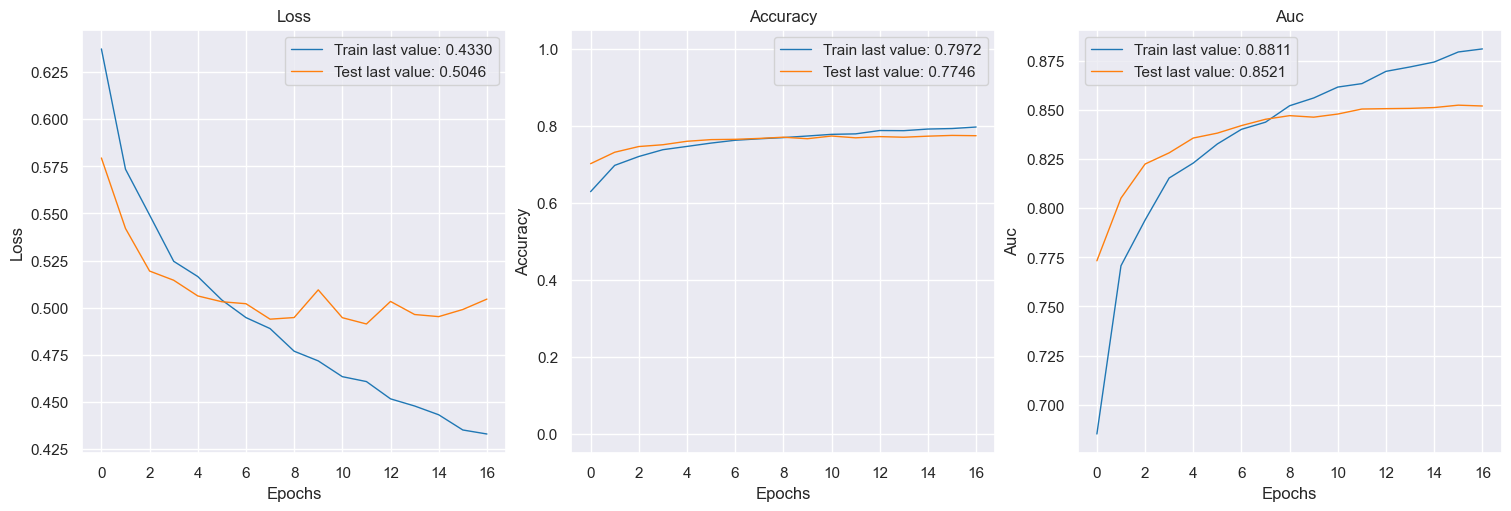

In [55]:
# Afficher evolution de l'accuracy et de la loss au cours des époques
show_history(history_LSTM_w2v)
plot_history(history_LSTM_w2v)
plt.savefig('conv_history_LSTM_w2v.png')
plt.close()

In [56]:
train_accu, train_AUC, test_accu, test_AUC, test_pred_time = evaluate_model(
    model_LSTM_w2v,
    X_train_padded,
    y_train,
    X_test_padded,
    y_test
)

Train Accuracy: 0.809
Train AUC: 0.891
Test Accuracy: 0.773
Test AUC: 0.859


In [57]:
metrics = {
    'Train Accuracy': train_accu,
    'Test Accuracy': test_accu,
    'Train AUC': train_AUC,
    'Test AUC': test_AUC,
}

In [58]:
times = {
    'fit_time': fit_time, 
    'test_predict_time': test_pred_time
}

In [60]:
y_proba_test = model_LSTM_w2v.predict(X_test_padded, batch_size=32, verbose=0)
fpr, tpr, _ = roc_curve(y_test, y_proba_test)
sns.set()
plt.figure()
plt.plot(fpr, tpr, label='ROC curve')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title(f'ROC Curve (Test Data) - Modèle LSTM - AUC = {test_AUC:.3f}',
          fontweight='bold', fontsize=14)
plt.savefig('roc_curve_LSTM_w2v.png')
plt.close()

In [61]:
artifacts = {
    'roc_curve': 'roc_curve_LSTM_w2v.png',
    'conv_history': 'conv_history_LSTM_w2v.png'
}

In [62]:
params = log_model_params(model_LSTM_w2v)

In [63]:
example_text = "This is an example tweet for input serialization."

# Tokeniser l'exemple avec le même tokenizer utilisé pour l'entraînement
example_sequence = tokenizer.texts_to_sequences([example_text])

# Appliquer le padding pour garantir que l'exemple a la bonne longueur
input_example = pad_sequences(example_sequence, maxlen=max_len)

log_experiment(
    model_LSTM_w2v,
    params,
    metrics,
    artifacts,
    input_example,
    times
)

1/1 [==============================] - 0s 445ms/step


1/1 [==============================] - 1s 737ms/step
Modèle et résultats enregistrés dans MLFlow sous le run ID: 97b2ed07c15b4aa7b4fce169db322452


## LSTM avec embeddings Glove

In [80]:
def glove_embedding_matrix(tokenizer, max_words, embedding_dim=100):
    """
    Crée une matrice d'embedding à partir des embeddings GloVe chargés via Gensim.

    :param tokenizer: Tokenizer ajusté sur le texte.
    :param max_words: Nombre de mots dans le vocabulaire.
    :param embedding_dim: Dimension des embeddings GloVe.
    :return: Matrice d'embedding.
    """
    # Charger les embeddings GloVe via Gensim
    # glove_model = api.load('glove-wiki-gigaword-100')
    glove_model = api.load('glove-twitter-100')

    # Créer une matrice d'embedding
    embedding_matrix = np.zeros((max_words, embedding_dim))

    for word, i in tokenizer.word_index.items():
        if i < max_words:
            if word in glove_model:
                embedding_matrix[i] = glove_model[word]

    return embedding_matrix

In [81]:
# embeddings glove
embedding_matrix = glove_embedding_matrix(tokenizer, max_words, 
                                          embedding_dim=100)

In [82]:
model_LSTM_glove = build_LSTM_model(embedding_matrix)
model_LSTM_glove.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         2000000   
                                                                 
 bidirectional (Bidirection  (None, 128)               84480     
 al)                                                             
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 2084609 (7.95 MB)
Trainable params: 84609 (330.50 KB)
Non-trainable params: 2000000 (7.63 MB)
_________________________________________________________________


In [83]:
callbacks_LSTM_glove = create_callbacks(model_name="model_LSTM_glove",
                                        patience=5)

In [84]:
# Entrainement
start_fit_time = time.time() 
history_LSTM_glove = model_LSTM_glove.fit(
    X_train_padded, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    callbacks=callbacks_LSTM_glove,
    verbose=1
)
fit_time = time.time() - start_fit_time

Epoch 1/20
320/320 [==============================] - ETA: 0s - loss: 0.6112 - accuracy: 0.6597 - auc: 0.7259
Epoch 1: val_loss improved from inf to 0.57673, saving model to ./checkpoints\model_LSTM_glove.keras
320/320 [==============================] - 57s 164ms/step - loss: 0.6112 - accuracy: 0.6597 - auc: 0.7259 - val_loss: 0.5767 - val_accuracy: 0.6945 - val_auc: 0.7885
Epoch 2/20
320/320 [==============================] - ETA: 0s - loss: 0.5557 - accuracy: 0.7142 - auc: 0.7878
Epoch 2: val_loss improved from 0.57673 to 0.53132, saving model to ./checkpoints\model_LSTM_glove.keras
320/320 [==============================] - 55s 172ms/step - loss: 0.5557 - accuracy: 0.7142 - auc: 0.7878 - val_loss: 0.5313 - val_accuracy: 0.7316 - val_auc: 0.8102
Epoch 3/20
320/320 [==============================] - ETA: 0s - loss: 0.5429 - accuracy: 0.7247 - auc: 0.7995
Epoch 3: val_loss did not improve from 0.53132
320/320 [==============================] - 53s 166ms/step - loss: 0.5429 - accuracy: 

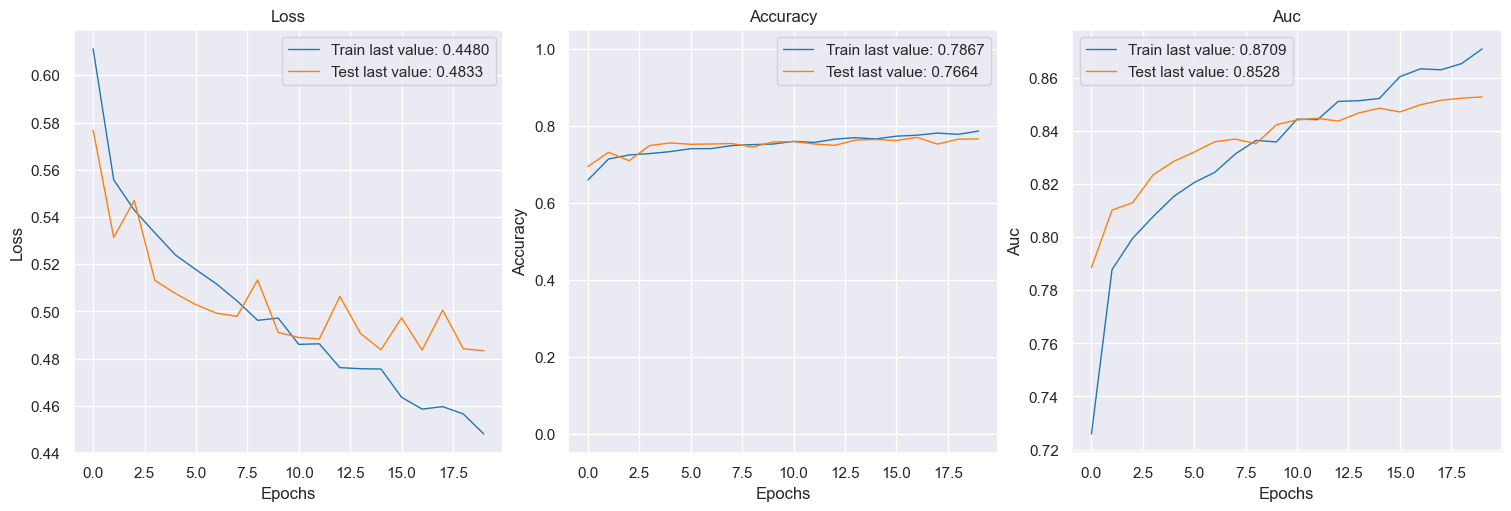

In [85]:
# Afficher evolution de l'accuracy et de la loss au cours des époques
show_history(history_LSTM_glove)
plot_history(history_LSTM_glove)
plt.savefig('conv_history_LSTM_glove.png')
plt.close()

In [86]:
train_accu, train_AUC, test_accu, test_AUC, test_pred_time = evaluate_model(
    model_LSTM_glove,
    X_train_padded,
    y_train,
    X_test_padded,
    y_test
)

Train Accuracy: 0.806
Train AUC: 0.892
Test Accuracy: 0.777
Test AUC: 0.862


In [87]:
metrics = {
    'Train Accuracy': train_accu,
    'Test Accuracy': test_accu,
    'Train AUC': train_AUC,
    'Test AUC': test_AUC,
}

times = {
    'fit_time': fit_time, 
    'test_predict_time': test_pred_time
}

y_proba_test = model_LSTM_glove.predict(X_test_padded, batch_size=32, verbose=0)
fpr, tpr, _ = roc_curve(y_test, y_proba_test)
sns.set()
plt.figure()
plt.plot(fpr, tpr, label='ROC curve')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title(f'ROC Curve (Test Data) - Modèle LSTM - AUC = {test_AUC:.3f}',
          fontweight='bold', fontsize=14)
plt.savefig('roc_curve_LSTM_glove.png')
plt.close()

artifacts = {
    'roc_curve': 'roc_curve_LSTM_glove.png',
    'conv_history': 'conv_history_LSTM_glove.png'
}

params = log_model_params(model_LSTM_glove)

In [88]:
log_experiment(
    model_LSTM_glove,
    params,
    metrics,
    artifacts,
    input_example,
    times
)

1/1 [==============================] - 4s 4s/step


1/1 [==============================] - 3s 3s/step
Modèle et résultats enregistrés dans MLFlow sous le run ID: dc5359821bd94b4b8ea451634887d3ae


In [89]:
model_LSTM_glove.save('model_LSTM.h5')

C:\Users\ngodinaud\Desktop\OpenClassrooms\Projets\Projet7\env\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Modèle avancé BERT

In [74]:
def prepare_BERT_datasets(X_train, X_test, y_train, y_test, max_len, batch_size,
                                          val_split=0.2, tokenizer=None):
    """
    Prépare les datasets TensorFlow pour l'entraînement avec un modèle BERT,
    en utilisant directement X_train et X_test.

    :param X_train: Liste ou array de textes d'entraînement.
    :param X_test: Liste ou array de textes de test.
    :param y_train: Labels associés aux textes d'entraînement.
    :param y_test: Labels associés aux textes de test.
    :param max_len: Longueur maximale des séquences BERT.
    :param batch_size: Taille des batchs.
    :param val_split: Proportion des données d'entraînement réservée à la validation.
    :param tokenizer: (Optionnel) Tokenizer BERT préchargé. Si None, charge 'distilbert-base-uncased'.

    :return: Tuple `(train_dataset, val_dataset, test_dataset, tokenizer, train_size)`
    """
    # Charger le tokenizer si non fourni
    if tokenizer is None:
        tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

    # Tokenisation des textes d'entraînement et de test
    train_inputs = tokenizer(list(X_train), max_length=max_len, padding=True, truncation=True, return_tensors="np")
    test_inputs = tokenizer(list(X_test), max_length=max_len, padding=True, truncation=True, return_tensors="np")

    train_input_ids = train_inputs['input_ids']
    train_attention_mask = train_inputs['attention_mask']
    test_input_ids = test_inputs['input_ids']
    test_attention_mask = test_inputs['attention_mask']

    # Taille d'entraînement pour le split val
    full_train_size = len(train_input_ids)
    val_size = int(full_train_size * val_split)
    train_size = full_train_size - val_size

    # Créer le dataset complet d'entraînement
    full_train_dataset = tf.data.Dataset.from_tensor_slices((
        {'input_ids': tf.constant(train_input_ids), 'attention_mask': tf.constant(train_attention_mask)},
        tf.constant(y_train)
    ))

    # Split en train/val
    train_dataset = full_train_dataset.take(train_size)
    val_dataset = full_train_dataset.skip(train_size)

    # Préparer le dataset test
    test_dataset = tf.data.Dataset.from_tensor_slices((
        {'input_ids': tf.constant(test_input_ids), 'attention_mask': tf.constant(test_attention_mask)},
        tf.constant(y_test)
    ))

    # Shuffle, batch, prefetch
    train_dataset = train_dataset.shuffle(train_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return train_dataset, val_dataset, test_dataset, tokenizer, train_size

In [75]:
def build_BERT_model(learning_rate, weight_decay_rate, train_data_size, epochs):
    
    model = TFDistilBertForSequenceClassification.from_pretrained(
        'distilbert-base-uncased',
        num_labels=1,
        dropout=0.5
    )

    num_train_steps = (train_data_size // batch_size) * epochs
    num_warmup_steps = int(0.1 * num_train_steps)

    optimizer, _ = create_optimizer(
        init_lr=learning_rate,
        num_train_steps=num_train_steps,
        num_warmup_steps=num_warmup_steps,
        weight_decay_rate=weight_decay_rate
    )

    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    metrics=[
            tf.keras.metrics.BinaryAccuracy(name='accuracy'),
            tf.keras.metrics.AUC(name='auc')
        ]

    model.compile(loss=loss, optimizer=optimizer, metrics=[metrics])

    return model

In [76]:
def evaluate_model_BERT(model, train_dataset, test_dataset):
    # Évaluer le modèle sur les données d'entraînement
    train_loss, train_accuracy, train_AUC = model.evaluate(train_dataset,
                                                           verbose=0)

    # Évaluer le modèle sur les données de test
    start_pred_time = time.time()
    test_loss, test_accuracy, test_AUC = model.evaluate(test_dataset,
                                                        verbose=0)
    test_pred_time = time.time() - start_pred_time
    
    print(f'Train Accuracy: {train_accuracy:.3f}')
    print(f'Train AUC: {train_AUC:.3f}')
    print(f'Test Accuracy: {test_accuracy:.3f}')
    print(f'Test AUC: {test_AUC:.3f}')

    return train_accuracy, train_AUC, test_accuracy, test_AUC, test_pred_time

In [77]:
max_len = 128
batch_size = 32
learning_rate = 2e-5
weight_decay_rate = 0.01
epochs = 6

In [78]:
# train_dataset, val_dataset, test_dataset, tokenizer, train_data_size = prepare_BERT_datasets(
#     texts=tweets_sample['text'].values,
#     labels=tweets_sample['target'].values,
#     max_len=max_len,
#     batch_size=batch_size
# )

In [79]:
train_dataset, val_dataset, test_dataset, tokenizer, train_data_size = prepare_BERT_datasets(
    X_train, X_test, y_train, y_test, max_len=128, batch_size=32, val_split=0.2
)

In [80]:
model_BERT = build_BERT_model(learning_rate, weight_decay_rate, train_data_size,
                             epochs)
model_BERT.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  769       
                                                                 
 dropout_19 (Dropout)        multiple                  0 (unused)
                                                                 
Total params: 66954241 (255.41 MB)
Trainable params: 66954241 (255.41 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [81]:
callbacks_BERT = create_callbacks(model_name="model_BERT",
                                        patience=3)

In [82]:
# Entrainement
start_fit_time = time.time() 
history_BERT = model_BERT.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=callbacks_BERT,
    verbose=1
)
fit_time = time.time() - start_fit_time

Epoch 1/6
 33/320 [==>...........................] - ETA: 21:09 - loss: 0.6924 - accuracy: 0.5123 - auc: 0.5164

KeyboardInterrupt: 

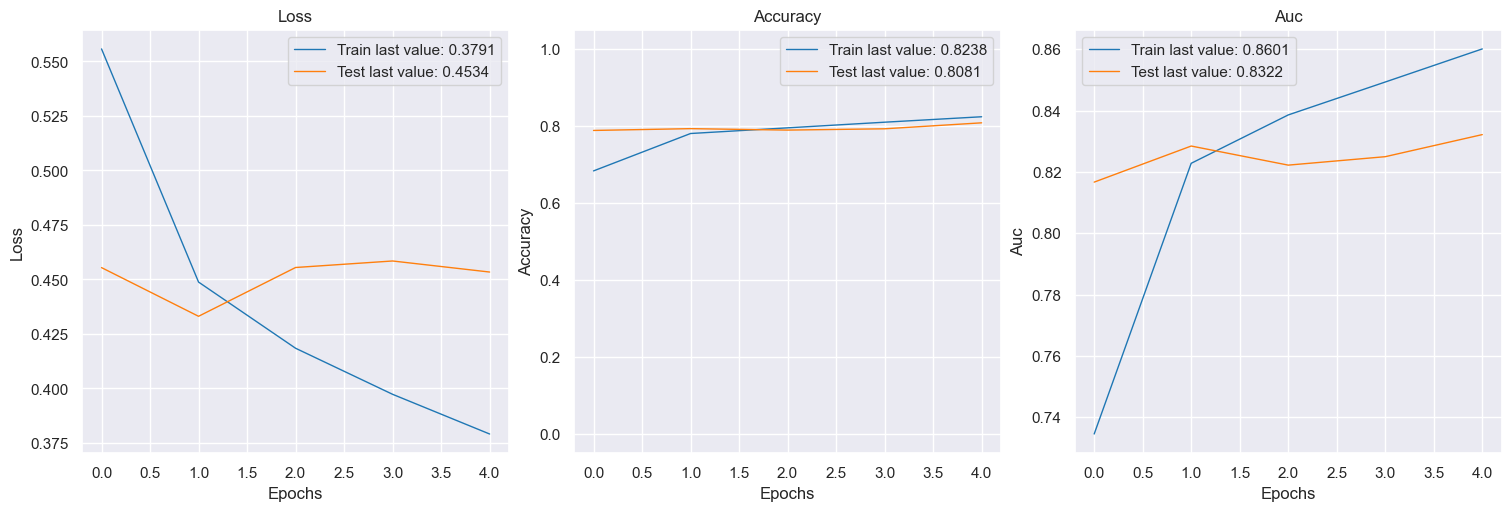

In [100]:
# Afficher evolution de l'accuracy et de la loss au cours des époques
show_history(history_BERT)
plot_history(history_BERT)
plt.savefig('conv_history_BERT.png')
plt.close()

In [101]:
train_accu, train_AUC, test_accu, test_AUC, test_pred_time = evaluate_model_BERT(
    model_BERT,
    train_dataset,
    test_dataset
)

Train Accuracy: 0.811
Train AUC: 0.846
Test Accuracy: 0.782
Test AUC: 0.817


In [102]:
metrics = {
    'Train Accuracy': train_accu,
    'Test Accuracy': test_accu,
    'Train AUC': train_AUC,
    'Test AUC': test_AUC,
}

times = {
    'fit_time': fit_time, 
    'test_predict_time': test_pred_time
}

y_proba_test = model_BERT.predict(test_dataset, batch_size=32, verbose=0)
fpr, tpr, _ = roc_curve(y_test, y_proba_test)
sns.set()
plt.figure()
plt.plot(fpr, tpr, label='ROC curve')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title(f'ROC Curve (Test Data) - Modèle BERT - AUC = {test_AUC:.3f}',
          fontweight='bold', fontsize=14)
plt.savefig('roc_curve_BERT.png')
plt.close()

artifacts = {
    'roc_curve': 'roc_curve_BERT.png',
    'conv_history': 'conv_history_BERT.png'
}

params = log_model_params(model_BERT)

ValueError: Found input variables with inconsistent numbers of samples: [9600, 1]

In [ ]:
# log_experiment(
#     model_BERT,
#     params,
#     metrics,
#     artifacts,
#     input_example,
#     times
# )

In [29]:
model = tf.keras.models.load_model('model_LSTM.keras')

ValueError: Layer 'embedding_1' expected 1 variables, but received 0 variables during loading. Expected: ['embedding_1/embeddings:0']